In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import cv2 as cv
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import cv2    

from sklearn.metrics import confusion_matrix

import os

Data seti drive'a yüklemiştim. Oradaki test ve train klasörlerinin path'lerini gösteriyorum. Böylece 5 class'ın isimleri listelenir.

In [4]:
train_path = '/content/gdrive/MyDrive/ImageClassificationDataSet/seg_train/seg_train'
test_path = '/content/gdrive/MyDrive/ImageClassificationDataSet/seg_test/seg_test'

print("type of Images in Train dataset"+str(os.listdir(train_path)))
print("type of Images in Test dataset"+str(os.listdir(test_path)))

type of Images in Train dataset['darunavir', '02-004', 'cox8a_targeted', 'hdac_inhibitor', 'leukemia']
type of Images in Test dataset['leukemia', 'hdac_inhibitor', 'darunavir', 'cox8a_targeted', '02-004']


In [5]:
pip install matplotlib==3.1.3

Her class'tan 5'er örnek çağırıyorum. Bu seçim random gerçekleşmektedir.

darunavir images:


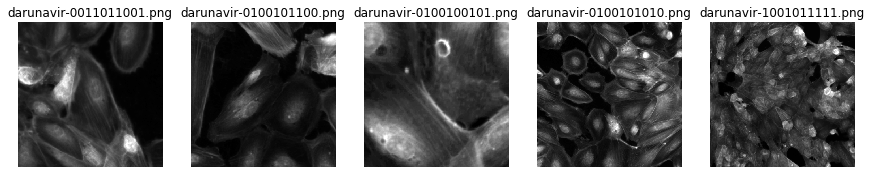

02-004 images:


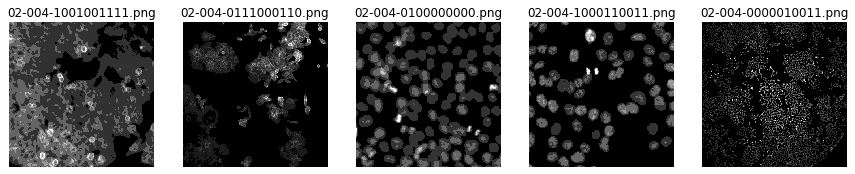

cox8a_targeted images:


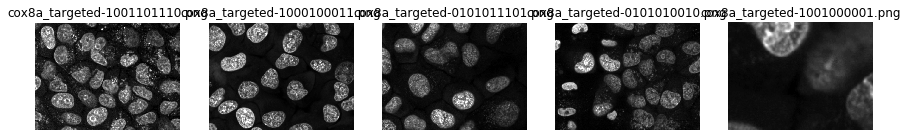

hdac_inhibitor images:


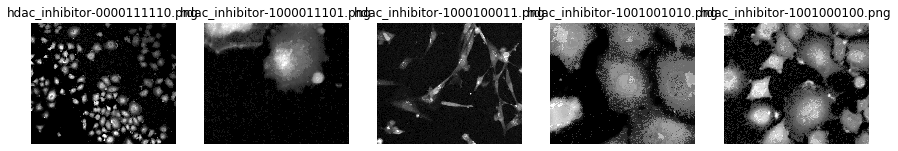

leukemia images:


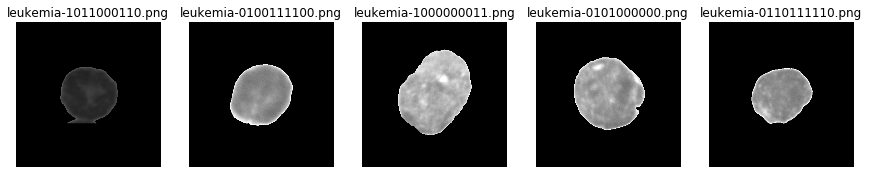

In [6]:
rows, cols = (1, 5)
import matplotlib.pyplot as plt
for categories in os.listdir(train_path):
    print(f'{categories} images:')
    path = f'{train_path}/{categories}'    
    fig = plt.figure(figsize = (15, 15))
    for i in range(rows * cols):
        fig.add_subplot(rows, cols, i+1)
        image_id = os.listdir(path)[np.random.randint(0, 500)]
        image = cv.imread(path + f'/{image_id}')
        plt.imshow(image[:, :, ::-1])
        plt.title(image_id)
        plt.axis('off')
    plt.show()

Gösterimleri yapılan class'ları title olarak listeliyorum.

In [7]:
from tqdm import tqdm
class_names = ['darunavir','02-004', 'cox8a_targeted', 'hdac_inhibitor', 'leukemia']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (227, 227)

In [8]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['/content/gdrive/MyDrive/ImageClassificationDataSet/seg_train/seg_train','/content/gdrive/MyDrive/ImageClassificationDataSet/seg_test/seg_test']
    output = []
    
    # Eğitim ve test setlerini yinelenir.
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Bir kategoriye(class) karşılık gelen her klasör yinelenir.
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Klasördeki her bir görüntü yinelenir.
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Görüntünün path'i alınır.
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Görüntü resize yapılır.
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Görüntü ve ilgili etiketi çıktıya eklenir.
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [9]:
(x_train, y_train), (x_test, y_test) = load_data()

Loading /content/gdrive/MyDrive/ImageClassificationDataSet/seg_train/seg_train


100%|██████████| 702/702 [00:05<00:00, 129.46it/s]


Loading /content/gdrive/MyDrive/ImageClassificationDataSet/seg_test/seg_test


100%|██████████| 200/200 [00:02<00:00, 92.03it/s] 


In [10]:
batch_size = 32  # orjinal batch_size=128 ile eğitilir.
epochs = 1
data_augmentation = True
num_classes = 10

# Doğruluğu(accuracy) arttırmak için piksel ortalaması çıkartılır.
subtract_pixel_mean = True

n = 3

version = 1

# Model parametresi n'den derinlik(depth) hesaplanır. 
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [11]:
input_shape = x_train.shape[1:]
print(input_shape)

(227, 227, 3)


In [12]:
# Normalizasyon yapılır.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [13]:
# Pixel ortalaması şartları sağlanırsa:
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (3507, 227, 227, 3)
3507 train samples
1000 test samples
y_train shape: (3507,)


In [15]:
from keras.utils import np_utils

In [16]:
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

In [17]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    
    80,120,160 epoch sonra learning rate düşürülür. Eğitim sırasında callbacklerin 
    bir parçası olarak her epoch otomatik olarak çağırılır.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [18]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): giriş görüntüsünden veya önceki katmandan giriş tensoru
        num_filters (int): Conv2D filtre sayısı
        kernel_size (int): Conv2D square kernel boyutu
        strides (int): Conv2D square stride boyutu
        activation (string): activation adı
        batch_normalization (bool): batch normalization dahil edilip edilmeyeceği
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): sonraki katmana input olarak tensor
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [19]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU 
    Last ReLU is after the shortcut connection.
    Her aşamanın başında, öznitelik eşleme boyutu, adım sayısı=2 olan 
    bir evrişim katmanı tarafından yarıya indirilir (aşağı örneklenir), 
    filtre sayısı ise ikiye katlanır. 
    Her aşamada, katmanlar aynı sayıda filtreye ve aynı sayıda filtreye sahiptir.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): image tensor girdisinin şekli
        depth (int): core convolutional layers sayısı
        num_classes (int): class sayısı (CIFAR10 has 10)

    # Returns
        model (Model): Keras model sabiti
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Model tanımına başlıyorum.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    #  Residual units stack'i örneklendirilir(instantiate)
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # ilk layer ama ilk stack değil
                strides = 2  # altörnek(downsample)
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # ilk layer ama ilk stack değil
                # linear projection residual shortcut connection to match
                # boyut değişti
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Sınıflandırıcı eklenir.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.(örneklenir)
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
     bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    İkinci ve sonraki kısayol bağlantısı kimliktir.
    Her aşamanın başında, filtre haritalarının sayısı iki katına çıkarken, 
    öznitelik haritası boyutu, adım sayısı=2 olan bir evrişim katmanı tarafından 
    yarıya indirilir (aşağı örneklenir). Her aşamada, katmanlar aynı sayıda 
    filtreye ve aynı filtre haritası boyutlarına sahiptir.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): girdi olarak görüntü tensorunun şekli
        depth (int): core convolutional layer sayısı
        num_classes (int): class sayısı (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Modele başlanır.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2, 2 path'e bölünmeden önce girişte BN-ReLU ile Conv2D gerçekleştirir.(bootleneck layer)
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Residual Unit stack'i örneklendirilir.
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # ilk layer ve ilk evre
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # ilk layer ama ilk evre değil
                    strides = 2    # (altörnek)downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # boyut değişti
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Sınıflandırıcı eklenir.
    # v2, Pooling aşamasından önce BN-ReLU yapar.
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Model instantiate yapılır.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [20]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'IntelImageClass_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Model kaydetme ve öğrenme oranı ayarlaması için callback hazırlanır.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 227, 227, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 227, 227, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                       

In [21]:
# Data augmentation olsa da olmasa da eğitim :
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # Preprocessing ve Real-time Veri Arttırma yapar:
    datagen = ImageDataGenerator(
        # dataset üzerinden giriş ortalamasını 0 olarak ayarlar
        featurewise_center=False,
        # her örneğin ortalamasını 0 olarak ayarlar.
        samplewise_center=False,
        # inputları datasetin std'sine ayırır.
        featurewise_std_normalization=False,
        # inputları kendi std'sine ayırır.
        samplewise_std_normalization=False,
        # ZCA whitening uygulama
        zca_whitening=False,
        zca_epsilon=1e-06,
        # görüntüleri rastgele döndürür (0-180 derece)
        rotation_range=0,
        # görüntüleri yatay olarak rastgele kaydırır
        width_shift_range=0.1,
        # görüntüleri dikey olarak rastgele kaydırır
        height_shift_range=0.1,
        # random shear için range ayarlar
        shear_range=0.,
        # random zoom için range
        zoom_range=0.,
        # random channel shifts için range
        channel_shift_range=0.,
        # giriş sınırlarının dışındaki noktaları doldurmak için modu ayarlar
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # rastgele yatay çevirir
        horizontal_flip=True,
        # rastgele dikey çevirir
        vertical_flip=False,
        # yeniden ölçeklendirme faktörünü ayarlar (herhangi bir başka dönüşümden önce uygulanır)
        rescale=None,
        # her girişe uygulanacak fonksiyonu ayarlar
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # doğrulama için ayrılmış görüntülerin oranı (0 ile 1 arasında)
        validation_split=0.0)

Using real-time data augmentation.


In [22]:
# Özellik normalleştirme(featurewise normalization) için gereken hesaplama miktarları
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [28]:
# Model datagen.flow() tarafından oluşturulan batchlere sığdırılır.
model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=6, verbose=1, workers=4,
                        callbacks = callbacks)

Learning rate:  0.001
Epoch 1/6
110/110 [==============================] - 86s 775ms/step - loss: 0.2653 - accuracy: 0.9598 - val_loss: 0.7217 - val_accuracy: 0.8540 - lr: 0.0010
Learning rate:  0.001
Epoch 2/6
110/110 [==============================] - 86s 776ms/step - loss: 0.2417 - accuracy: 0.9703 - val_loss: 0.6100 - val_accuracy: 0.8390 - lr: 0.0010
Learning rate:  0.001
Epoch 3/6
110/110 [==============================] - 86s 776ms/step - loss: 0.2529 - accuracy: 0.9626 - val_loss: 0.3359 - val_accuracy: 0.9400 - lr: 0.0010
Learning rate:  0.001
Epoch 4/6
110/110 [==============================] - 86s 776ms/step - loss: 0.2055 - accuracy: 0.9803 - val_loss: 0.2746 - val_accuracy: 0.9520 - lr: 0.0010
Learning rate:  0.001
Epoch 5/6
110/110 [==============================] - 87s 777ms/step - loss: 0.2179 - accuracy: 0.9752 - val_loss: 0.3294 - val_accuracy: 0.9410 - lr: 0.0010
Learning rate:  0.001
Epoch 6/6
110/110 [==============================] - 87s 777ms/step - loss: 0.2228 

In [29]:
def display_random_image(class_names, images, labels):
    """
       images dizisinden rastgele bir görüntü ve buna karşılık gelen etiketi labels dizisinden görüntülenir.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Predicte Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

In [30]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

32/32 [==============================] - 7s 217ms/step - loss: 0.5672 - accuracy: 0.8910
Test loss: 0.5671780109405518
Test accuracy: 0.890999972820282


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


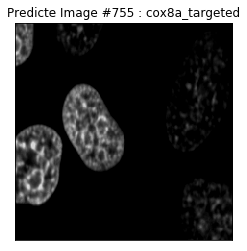

In [32]:
predictions = model.predict(x_test)     # Olasılık Vektörü
pred_labels = np.argmax(predictions, axis = 1) # En yüksek olasılık alınır.

display_random_image(class_names, x_test, pred_labels)